In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from scipy.stats import uniform
from sklearn.mixture import GaussianMixture
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
import emcee
import scipy.stats
import corner
import random
import dynesty

In [2]:
x = np.load('../solutions/transient.npy')
time = x[:,0]
flux = x[:,1]
df = x[:,2]

<ErrorbarContainer object of 3 artists>

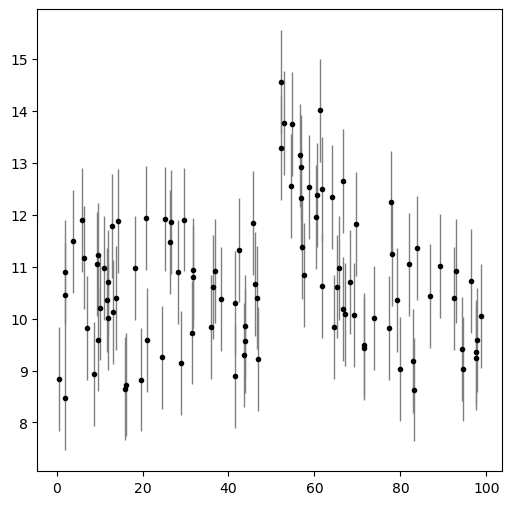

In [3]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')

In [4]:
def model(time, x):
    A,b,t0,alpha = x
    return np.where(time<t0,b,b+A*np.exp(-alpha*(time-t0)))

In [5]:
t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

In [6]:
t0_quick=50
A_quick=5
b_quick=10
alpha_quick=0.1
x_quick= np.array([A_quick,b_quick,t0_quick,alpha_quick])

In [7]:
def LogLikelihood(x, df, flux):
    y_fit = model(time, x)
    return -0.5 * np.sum((flux-y_fit)**2 / df**2) 

## prior is proportional to 1/alpha
def Logprior(x):
    A,b,t0,alpha=x 
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    return -np.inf
                   
def LogPosterior(x, df, flux):
    return LogLikelihood(x,df,flux) + Logprior(x)

In [8]:
ndim = 4  # number of parameters in the model
nwalkers = 24  # number of MCMC walkers
burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = x_quick + 1e-1* np.random.randn(nwalkers, ndim)

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[df, flux])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

C:\Users\restu\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


done


In [9]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain


(24, 100000, 4)
(2160000, 4)


(100000, 24, 4)


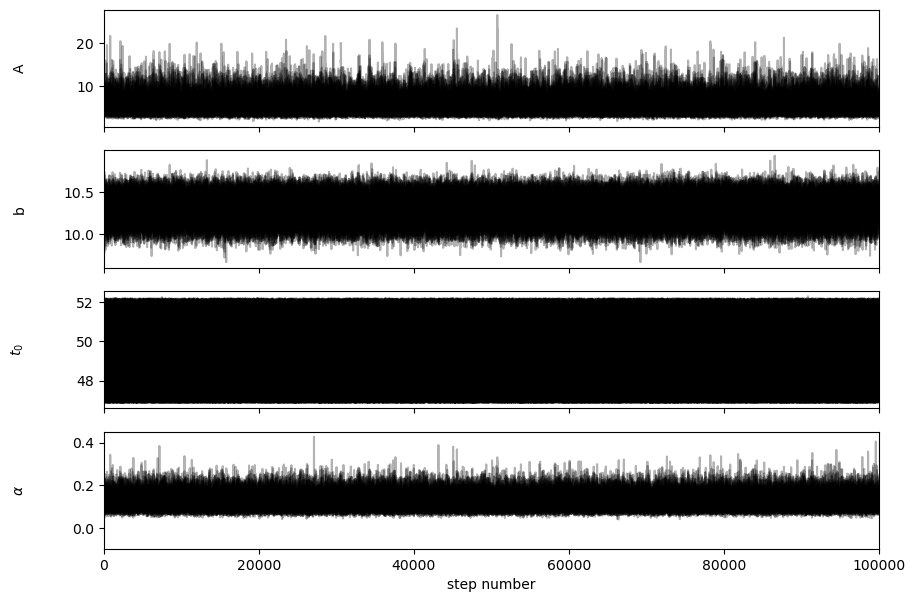

In [10]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["A","b",r"$t_{0}$",r"$\alpha$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
tau = sampler.get_autocorr_time()
print(tau)
thin = tau.astype(int) + 1
print(thin)

[80.74762073 61.51596743 79.32606421 65.15690078]
[81 62 80 66]


In [41]:
emcee_trace = sampler.get_chain(discard=int(burn/max(thin)), thin=max(thin), flat=True)
emcee_trace.shape

(29592, 4)

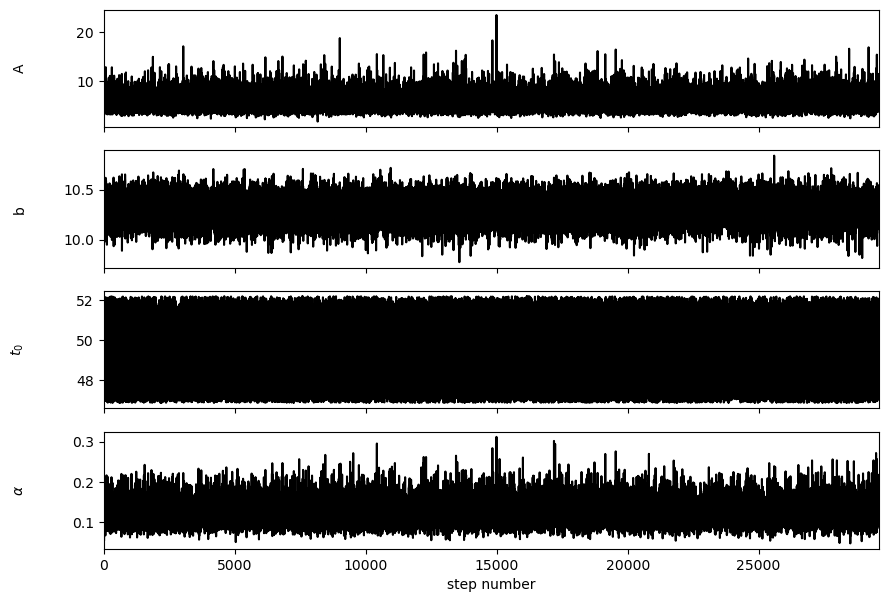

In [42]:
fig1, axes1 = plt.subplots(4, figsize=(10, 7), sharex=True)
for i in range(ndim):
    a = axes1[i]
    a.plot(emcee_trace[:,i], 'k')
    a.set_xlim(0, len(emcee_trace))
    a.set_ylabel(labels[i])
    a.yaxis.set_label_coords(-0.1, 0.5)

axes1[-1].set_xlabel("step number");

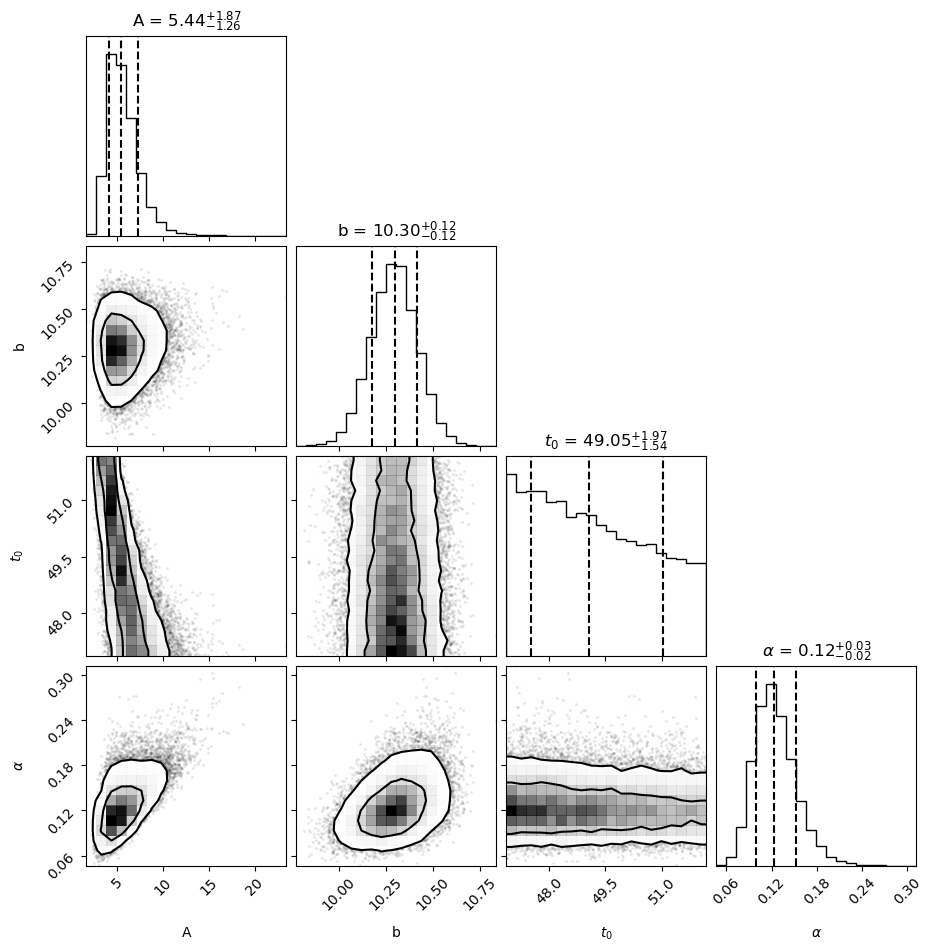

In [43]:
fig = corner.corner(emcee_trace, labels=labels, levels=[0.68,0.95], show_titles=True, quantiles=[0.16, 0.5, 0.84]);

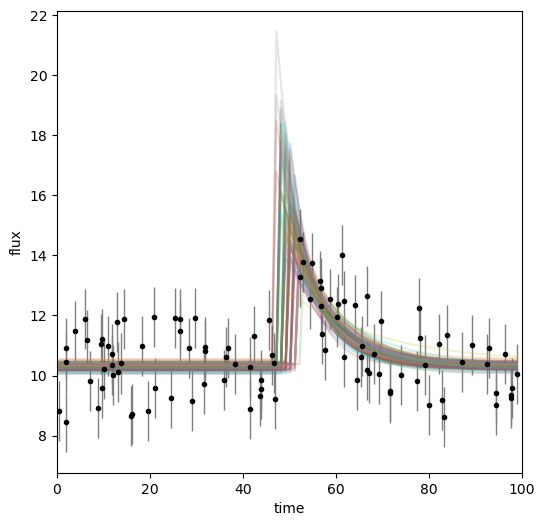

In [59]:
new_sample = np.array(random.sample(emcee_trace.tolist(), 100))
fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
xgrid = np.linspace(min(time), max(time),len(time))
[ax2.plot(xgrid, model(xgrid, mod), alpha=0.2) for mod in new_sample];
ax2.set_xlim(0, len(new_sample))
ax2.set_ylabel('flux')
ax2.set_xlabel('time');

In [63]:
median = np.median(emcee_trace, axis = 0)

array([ 5.43793676, 10.2971788 , 49.05398377,  0.12263069])

In [72]:
low, med, up = np.percentile(emcee_trace, [5, 50, 95], axis=0)
qup = up-med
qdw = med-low
print(r'$A=%f_{+%f}$' % (med[0], qup[0]))

$A=5.437937_{+3.450026}$


In [82]:
from IPython.display import display, Latex
display(Latex(r'$A=%f_{+%f}$') %(med[0], qup[0]))

TypeError: unsupported operand type(s) for %: 'Latex' and 'tuple'